In [1]:
import pandas as pd
import numpy as np

with open('../datasets/mimic2/mimic2.attr') as f:
    featureNames = []
    for line in f.readlines():
        featureNames.append(line[:line.find(':')])
        
with open('../datasets/mimic2/mimic2_cont_missing.data') as f:
    data_orig = pd.read_csv(f,' ',header=None, na_values='N/A')
data_orig.columns = featureNames

with open('../datasets/mimic2/mimic2_cont_meanimputed.data') as f:
    data_meanimputed = pd.read_csv(f,' ',header=None, na_values='N/A')
data_meanimputed.columns = featureNames

In [2]:
data_orig.isnull().mean(0)

Age                  0.000000
GCS                  0.000000
SBP                  0.447609
HR                   0.031214
Temperature          0.000000
PFratio              0.543822
Renal                0.000000
Urea                 0.004039
WBC                  0.005345
CO2                  0.870002
Na                   0.004448
K                    0.003672
Bilirubin            0.344785
AdmissionType        0.000000
AIDS                 0.000000
MetastaticCancer     0.000000
Lymphoma             0.000000
HospitalMortality    0.000000
dtype: float64

In [2]:
train_cols = data_orig.columns[0:-1]
label_col = data_orig.columns[-1]
X_means = data_orig[train_cols].mean()
X_medians = data_orig[train_cols].median()

### train the EBMs

In [3]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

In [4]:
ebm_mean = ExplainableBoostingClassifier(inner_bags=100, outer_bags=100, interactions=0,random_state=1, n_jobs=-1)
ebm_mean.fit(data_meanimputed[train_cols], data_meanimputed[label_col])

ExplainableBoostingClassifier(binning='quantile', early_stopping_rounds=50,
                              early_stopping_tolerance=0.0001,
                              feature_names=['Age', 'GCS', 'SBP', 'HR',
                                             'Temperature', 'PFratio', 'Renal',
                                             'Urea', 'WBC', 'CO2', 'Na', 'K',
                                             'Bilirubin', 'AdmissionType',
                                             'AIDS', 'MetastaticCancer',
                                             'Lymphoma'],
                              feature_types=['continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous',...
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous'

In [6]:
ebm_median = ExplainableBoostingClassifier(inner_bags=100, outer_bags=100, interactions=0,random_state=1, n_jobs=-1)
ebm_median.fit(data_medianimputed[train_cols], data_medianimputed[label_col])

ExplainableBoostingClassifier(binning='quantile', early_stopping_rounds=50,
                              early_stopping_tolerance=0.0001,
                              feature_names=['Age', 'GCS', 'SBP', 'HR',
                                             'Temperature', 'PFratio', 'Renal',
                                             'Urea', 'WBC', 'CO2', 'Na', 'K',
                                             'Bilirubin', 'AdmissionType',
                                             'AIDS', 'MetastaticCancer',
                                             'Lymphoma'],
                              feature_types=['continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous',...
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous'

In [7]:
ebm_left = ExplainableBoostingClassifier(inner_bags=100, outer_bags=100, interactions=0,random_state=1, n_jobs=-1)
ebm_left.fit(data_left[train_cols], data_left[label_col])

ExplainableBoostingClassifier(binning='quantile', early_stopping_rounds=50,
                              early_stopping_tolerance=0.0001,
                              feature_names=['Age', 'GCS', 'SBP', 'HR',
                                             'Temperature', 'PFratio', 'Renal',
                                             'Urea', 'WBC', 'CO2', 'Na', 'K',
                                             'Bilirubin', 'AdmissionType',
                                             'AIDS', 'MetastaticCancer',
                                             'Lymphoma'],
                              feature_types=['continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous',...
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous'

In [21]:
ebm_right = ExplainableBoostingClassifier(inner_bags=100, outer_bags=100, interactions=0,random_state=1, n_jobs=-1)
ebm_right.fit(data_right[train_cols], data_right[label_col])

ExplainableBoostingClassifier(binning='quantile', early_stopping_rounds=50,
                              early_stopping_tolerance=0.0001,
                              feature_names=['Age', 'GCS', 'SBP', 'HR',
                                             'Temperature', 'PFratio', 'Renal',
                                             'Urea', 'WBC', 'CO2', 'Na', 'K',
                                             'Bilirubin', 'AdmissionType',
                                             'AIDS', 'MetastaticCancer',
                                             'Lymphoma'],
                              feature_types=['continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous',...
                                             'continuous', 'continuous',
                                             'continuous', 'continuous',
                                             'continuous', 'continuous'

### detect bumps

In [9]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [10]:
missing_ratios = data_orig.isnull().mean()

In [16]:
def detect_bumps(ebm, data, featureNames, missing_ratios, impute_type, threshold = 0.6):
    X_means = data.mean(0)
    X_medians = data.median(0)
    n_bins = 0
    n_outliers = 0
    for i, featureName in enumerate(featureNames[:-1]):
        if ebm.preprocessor_.col_types_[i] == 'continuous' and i not in [1,4,6]:
            x_mean = X_means[i]
            x_median = X_medians[i]
            scores = ebm.additive_terms_[i]
            bins = np.zeros(scores.shape)
            bins[1:-1] = ebm.preprocessor_.col_bin_edges_[i]
            bins[0] = ebm.preprocessor_.col_min_[i]
            bins[-1] = ebm.preprocessor_.col_max_[i]
            x_density = np.histogram(data.values[:,i],bins=bins)[0]/data.shape[0]
            x_scores = scores[1:]
            x_density_g2 = x_density[:-2]+x_density[2:]-2*x_density[1:-1]
#             x_scores_g2 = x_scores[:-2]+x_scores[2:]-2*x_scores[1:-1]
            bin_width =  bins[1:] - bins[:-1]
            bin_width_mid = (bin_width[1:]+bin_width[:-1])/2
#             print(bin_width.shape, x_scores.shape)
            x_scores_g2 = (x_scores[2:]-x_scores[1:-1])/bin_width_mid[:-1] - (x_scores[1:-1]- x_scores[:-2])/bin_width_mid[1:]
            X_features = np.concatenate([x_density_g2.reshape((-1,1)),x_scores_g2.reshape((-1,1))],axis=1)
            
            outlier_detector = IsolationForest(n_estimators=200)
            outlier_detector.fit(x_scores_g2.reshape((-1,1)))
            y_scores = outlier_detector.score_samples(x_scores_g2.reshape((-1,1)))
            y = (y_scores > -threshold).astype('int32') * 2 - 1
            idx=np.where(y==-1)[0]
            outlier_ratio = idx.shape[0]/y.shape[0]
            n_bins += y.shape[0]
            n_outliers += idx.shape[0]
            print(f'{i} Feature Name: ', featureName)
            print(f"mean: {x_mean}, median: {x_median}")
            print('outlier ratio = ', outlier_ratio)
            print('missing ratio = ', missing_ratios[i])
            
            mean_idx = np.argmax(bins>x_mean) - 2
            median_idx = np.argmax(bins>x_median) - 2
            is_mean_outlier = mean_idx > 0  and mean_idx < len(y) and y[mean_idx]==-1
            is_median_outlier = median_idx > 0  and median_idx < len(y) and y[median_idx]==-1
            print('is mean outlier?', is_mean_outlier)
            print('is median outlier?', is_median_outlier)
            print(f"bin index (mean): {mean_idx}, bin index (median): {median_idx}")
            print("-----------------------------------------------------------------------")
            
            plt.figure(figsize=(10,8))
            gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 
            plt.subplot(gs[0])
            plt.step(bins,scores,label='pre (default)')
            plt.vlines((bins[idx+1]+bins[idx+2])/2,-1,2,color='r',linestyles='dashed',alpha=.7)
            plt.vlines(x_mean,-1,2,color='g',linestyles='dashed',alpha=.7)
            plt.vlines(x_median,-1,2,color='y',linestyles='dashed',alpha=.7)
            plt.xlim([bins[0]+1e-4*(bins[-1]-bins[0]),bins[-1]])
            plt.ylim([-1,2])
            plt.xlabel(featureNames[i],fontsize=14)
            plt.ylabel(featureNames[-1],fontsize=14)
            plt.subplot(gs[1])
            plt.hist(data.values[:,i],bins,alpha=.7)
            plt.xlim([bins[0]+1e-4*(bins[-1]-bins[0]),bins[-1]])
            plt.xlabel(featureNames[i],fontsize=14)
            plt.ylabel('density',fontsize=14)
            plt.savefig(f'mimic2_bumps/{impute_type}/{i}_{featureNames[i]}.png', dpi=300)
            
            plt.figure(figsize=(10,6))
            plt.step(bins,scores,label='pre (default)')
            if is_mean_outlier:
                plt.vlines(x_mean,-1,2,color='r',linestyles='dashed',alpha=.7)
            else:
                plt.vlines(x_mean,-1,2,color='g',linestyles='dashed',alpha=.7)
            plt.xlim([bins[0]+1e-4*(bins[-1]-bins[0]),bins[-1]])
            plt.ylim([-1,2])
            plt.xlabel(featureNames[i],fontsize=14)
            plt.ylabel(featureNames[-1],fontsize=14)
            plt.savefig(f'mimic2_bumps/{impute_type}/{i}_{featureNames[i]}_mean.png', dpi=300)
            
            plt.figure(figsize=(10,6))
            plt.step(bins,scores,label='pre (default)')
            if is_mean_outlier:
                plt.vlines(x_median,-1,2,color='r',linestyles='dashed',alpha=.7)
            else:
                plt.vlines(x_median,-1,2,color='g',linestyles='dashed',alpha=.7)
            plt.xlim([bins[0]+1e-4*(bins[-1]-bins[0]),bins[-1]])
            plt.ylim([-1,2])
            plt.xlabel(featureNames[i],fontsize=14)
            plt.ylabel(featureNames[-1],fontsize=14)
            plt.savefig(f'mimic2_bumps/{impute_type}/{i}_{featureNames[i]}_median.png', dpi=300)
            
            plt.figure(figsize=(6,6))
            plt.scatter(X_features[:,0],X_features[:,1],c=y,vmin=-1,vmax=1,alpha=.7,linewidths=2)
            plt.xlabel('density 2nd order derivative',fontsize=14)
            plt.ylabel('score 2nd order derivative',fontsize=14)
            plt.savefig(f'mimic2_bumps/{impute_type}/{i}_{featureNames[i]}_scatterplot.png', dpi=100)
            
    print('global outlier ratio =',n_outliers/n_bins)

### Impute with the mean

0 Feature Name:  Age
mean: 63.23349438929373, median: 64.95687885010265
outlier ratio =  0.05928853754940711
missing ratio =  0.0
is mean outlier? False
is median outlier? False
bin index (mean): 117, bin index (median): 126
-----------------------------------------------------------------------
2 Feature Name:  SBP
mean: 118.12993056579296, median: 118.12993056581476
outlier ratio =  0.08333333333333333
missing ratio =  0.4476089440182797
is mean outlier? False
is median outlier? False
bin index (mean): 60, bin index (median): 60
-----------------------------------------------------------------------
3 Feature Name:  HR
mean: 88.57843574929096, median: 88.0
outlier ratio =  0.08547008547008547
missing ratio =  0.0312142973722866
is mean outlier? True
is median outlier? False
bin index (mean): 48, bin index (median): 47
-----------------------------------------------------------------------
5 Feature Name:  PFratio
mean: 332.6007733518728, median: 332.60077335176777
outlier ratio =  0.

<ipython-input-16-1551c3d75f11>:47: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



9 Feature Name:  CO2
mean: 24.167608286253838, median: 24.16760828625235
outlier ratio =  0.11428571428571428
missing ratio =  0.870001632120124
is mean outlier? False
is median outlier? False
bin index (mean): 18, bin index (median): 18
-----------------------------------------------------------------------
10 Feature Name:  Na
mean: 138.291897208902, median: 139.0
outlier ratio =  0.0784313725490196
missing ratio =  0.004447527338012077
is mean outlier? False
is median outlier? False
bin index (mean): 26, bin index (median): 27
-----------------------------------------------------------------------
11 Feature Name:  K
mean: 4.300529527397791, median: 4.2
outlier ratio =  0.07246376811594203
missing ratio =  0.0036722702790925412
is mean outlier? False
is median outlier? False
bin index (mean): 22, bin index (median): 20
-----------------------------------------------------------------------
12 Feature Name:  Bilirubin
mean: 1.3123552123549898, median: 1.0
outlier ratio =  0.052238805

C:\Users\t-zhichen\Anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:464: RuntimeWarning:

invalid value encountered in true_divide



13 Feature Name:  AdmissionType
mean: 1.1649665415374573, median: 2.0
outlier ratio =  1.0
missing ratio =  0.0
is mean outlier? False
is median outlier? False
bin index (mean): 0, bin index (median): -2
-----------------------------------------------------------------------
global outlier ratio = 0.06779661016949153


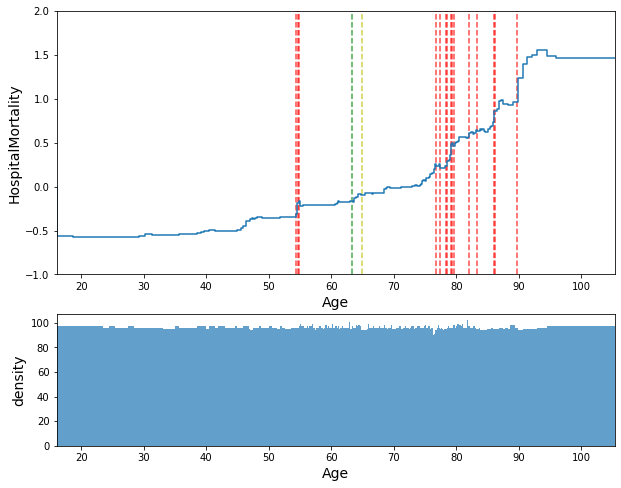

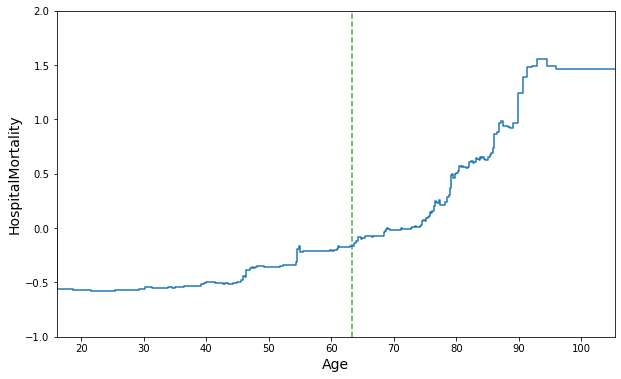

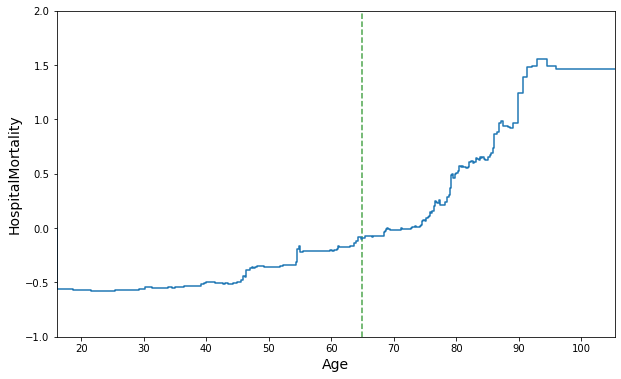

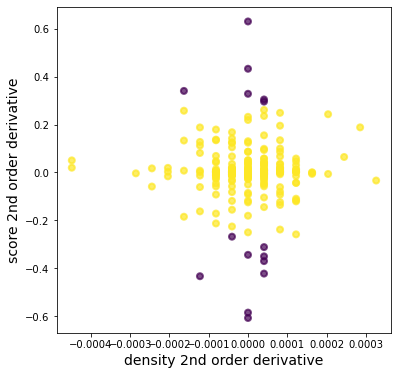

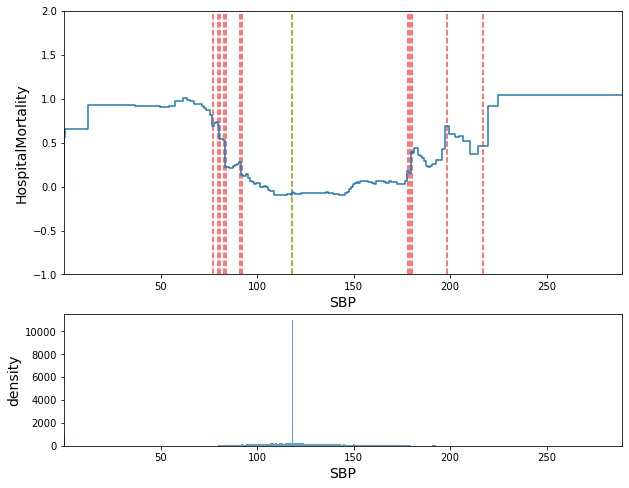

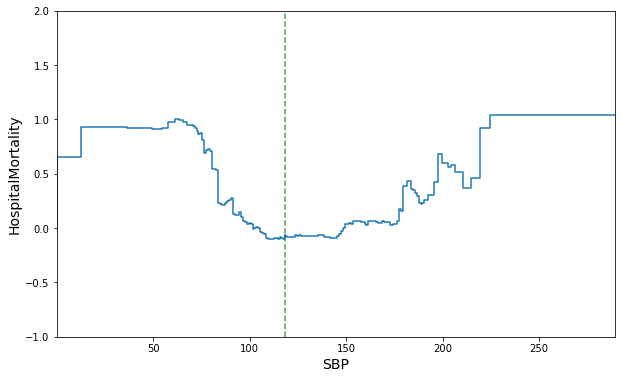

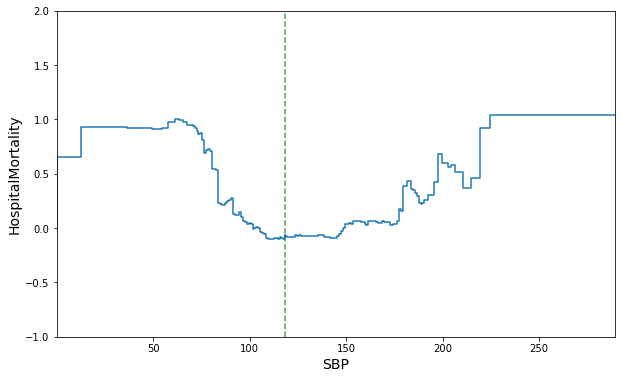

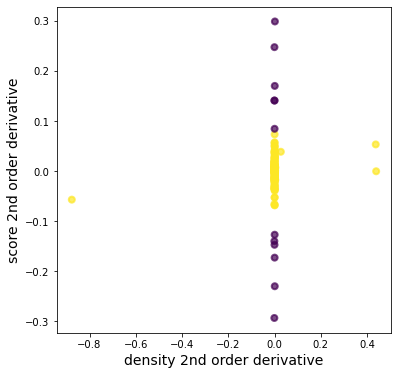

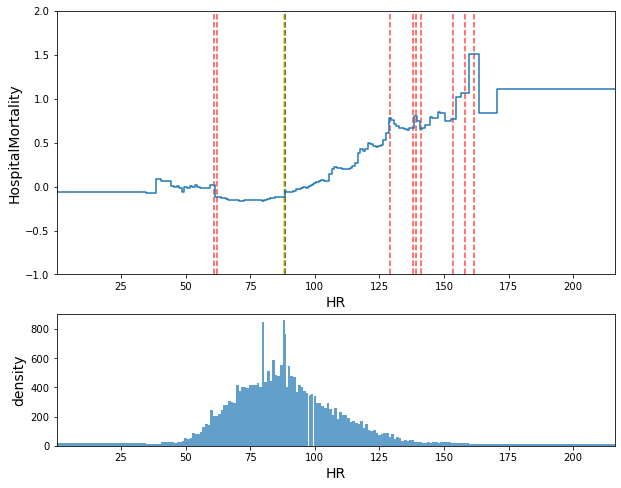

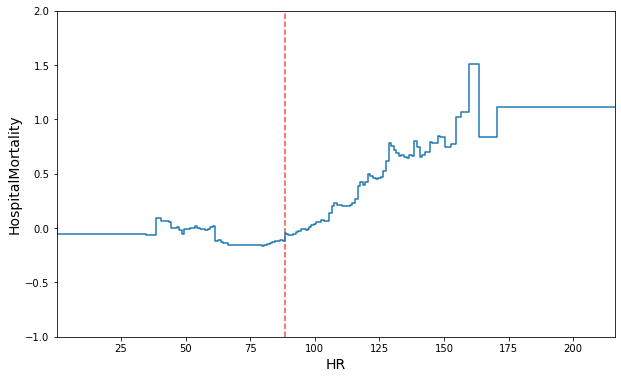

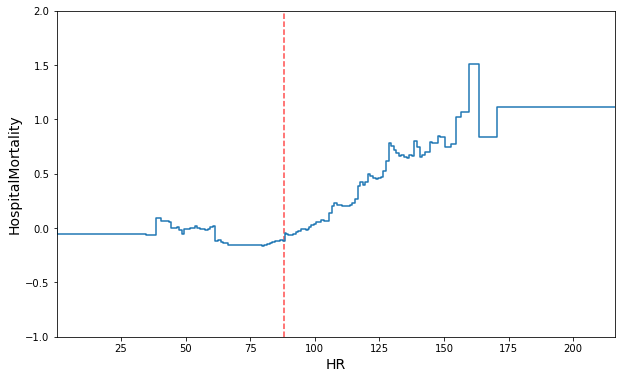

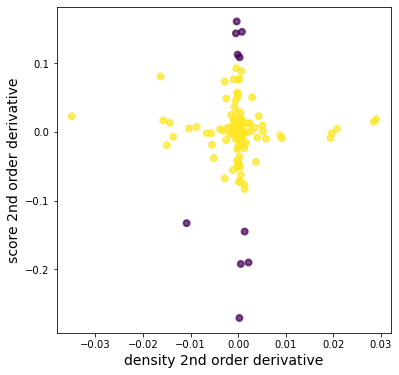

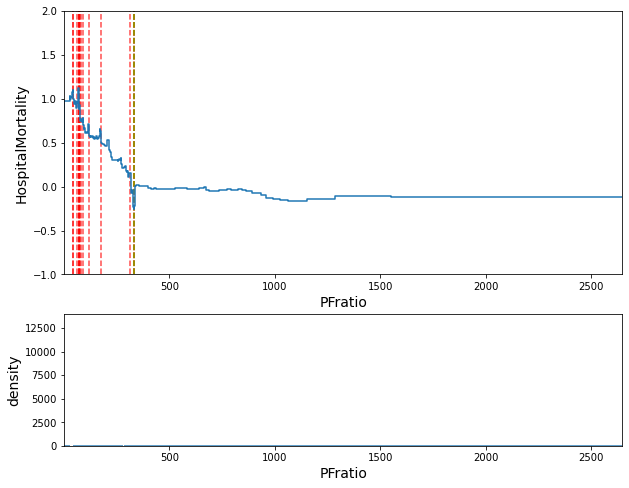

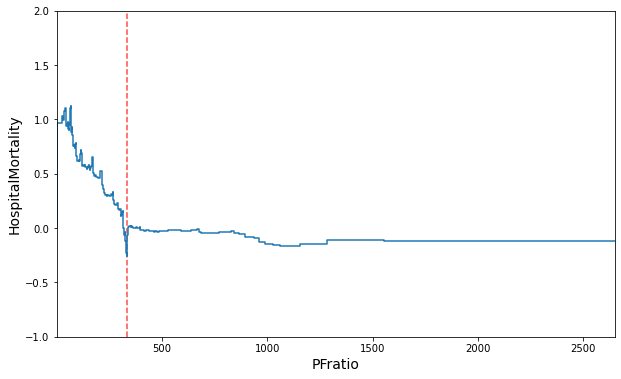

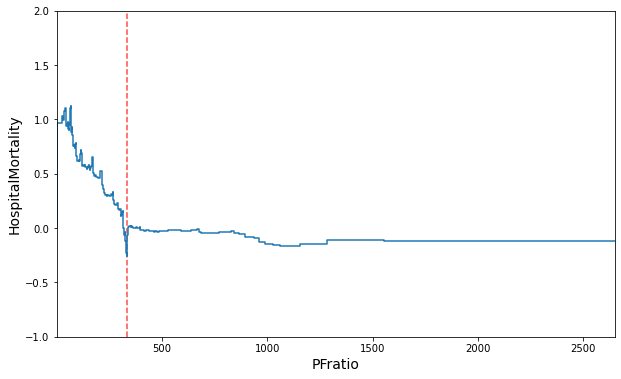

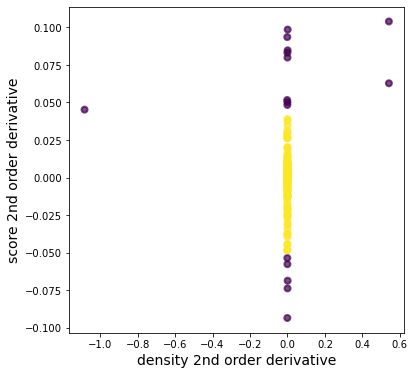

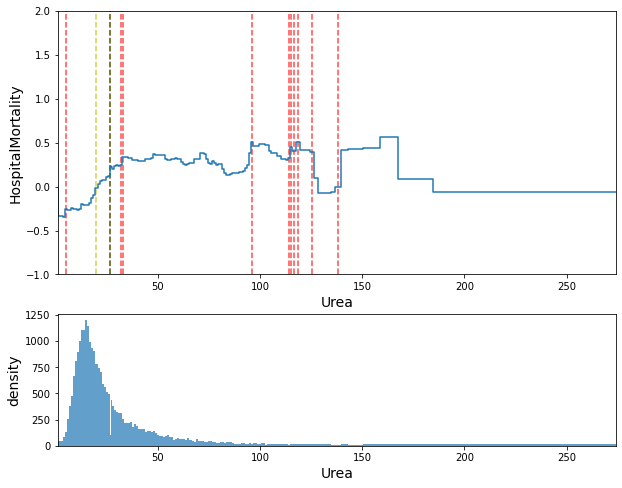

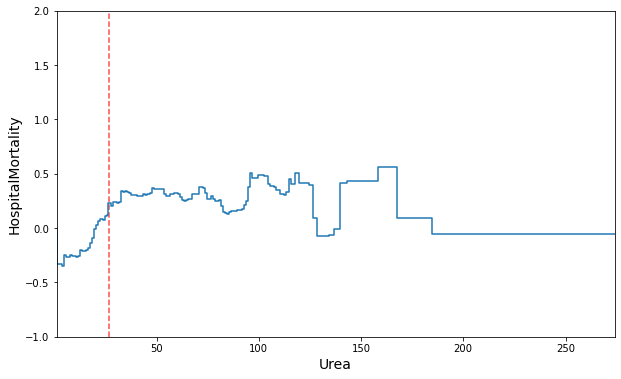

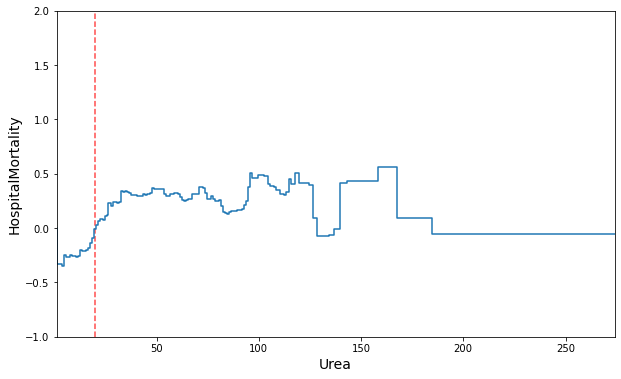

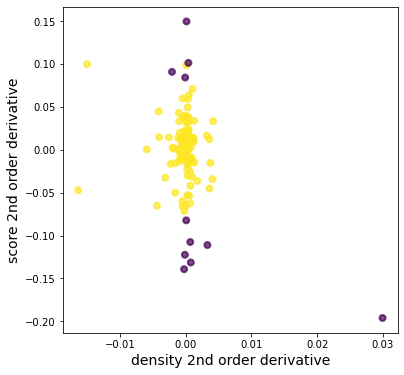

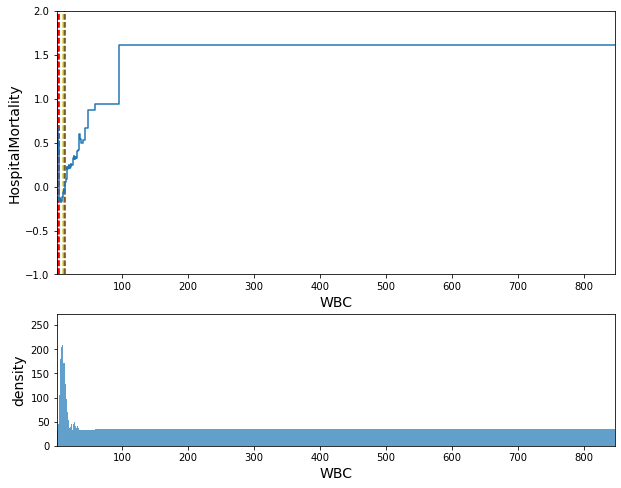

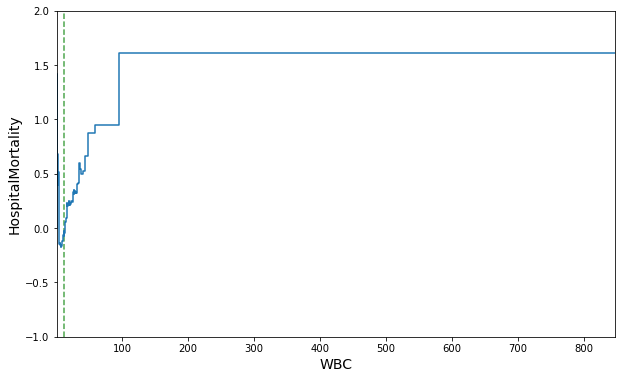

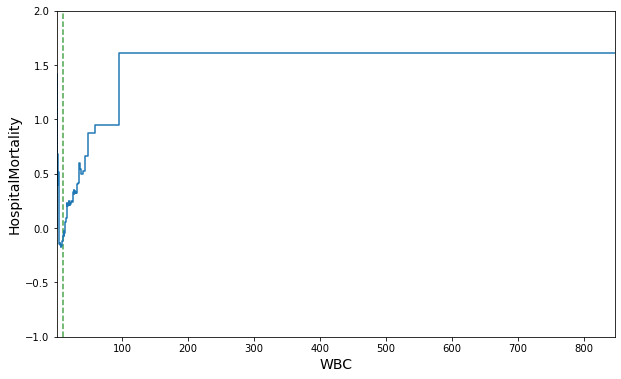

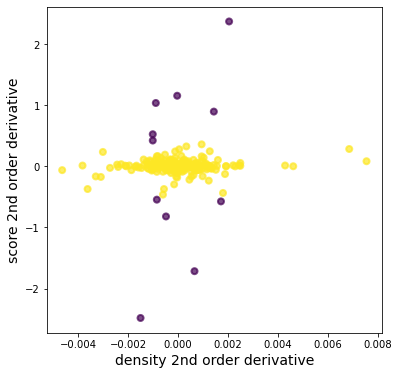

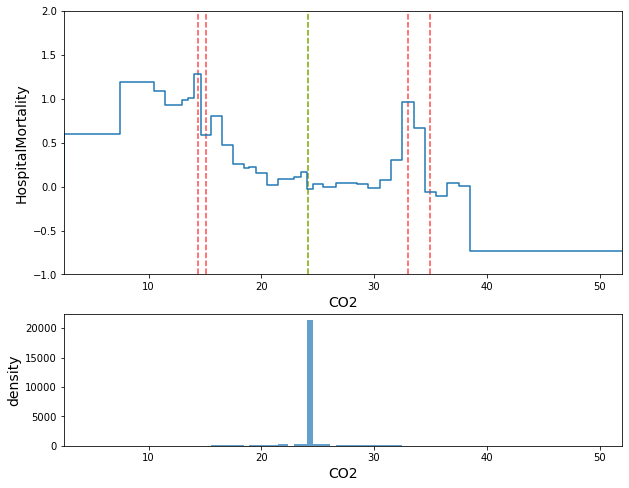

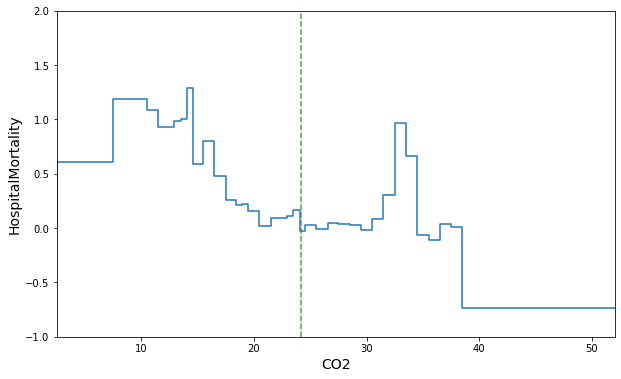

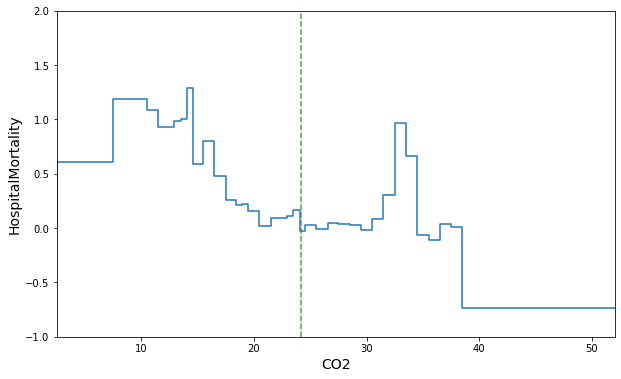

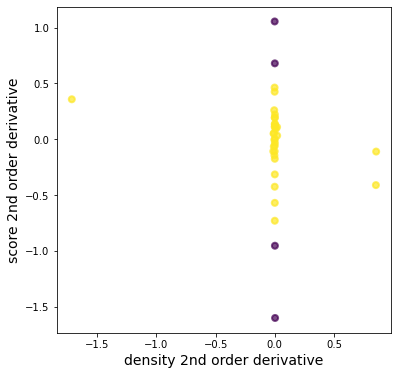

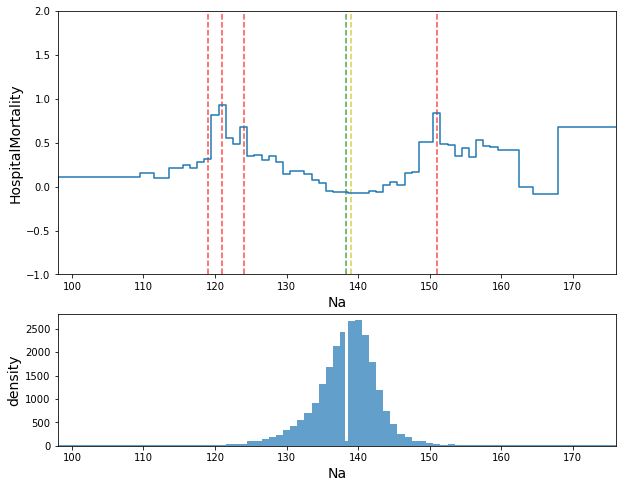

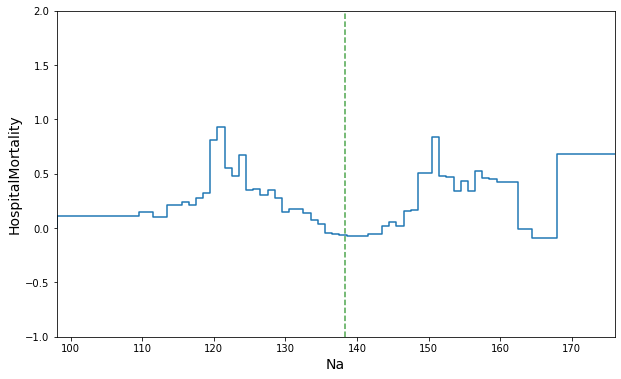

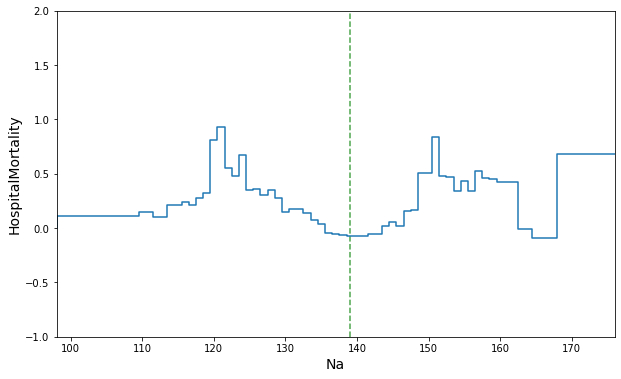

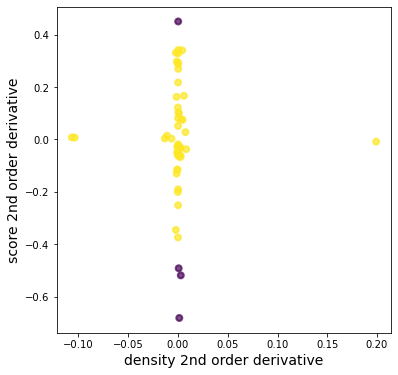

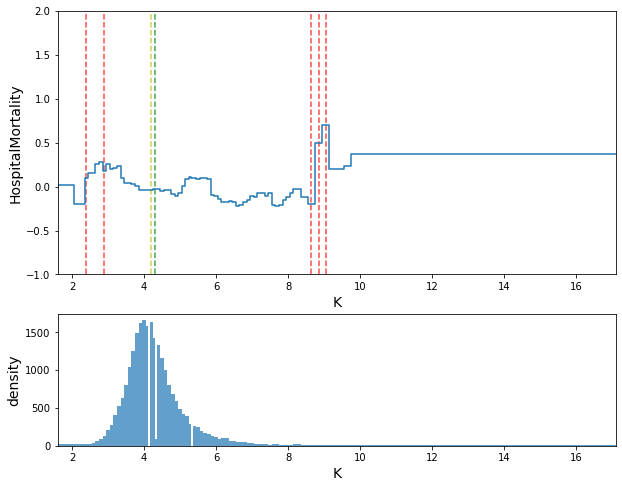

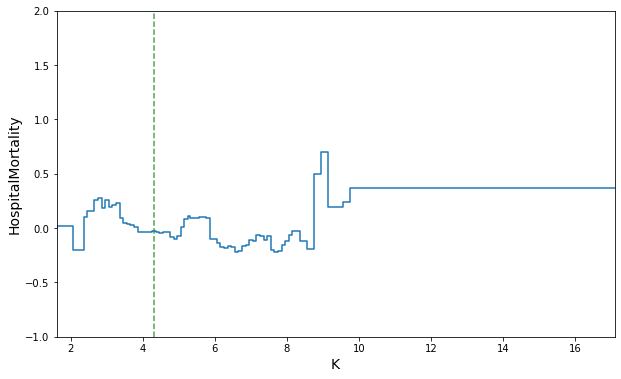

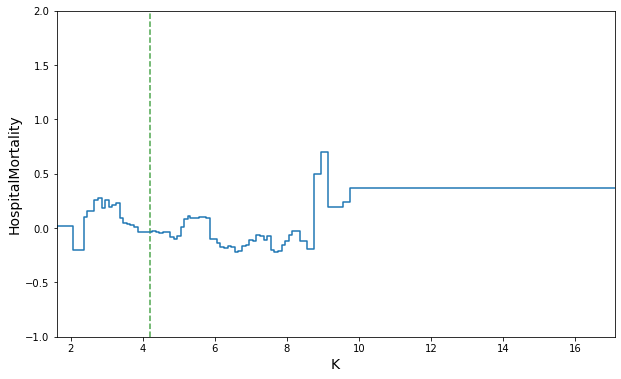

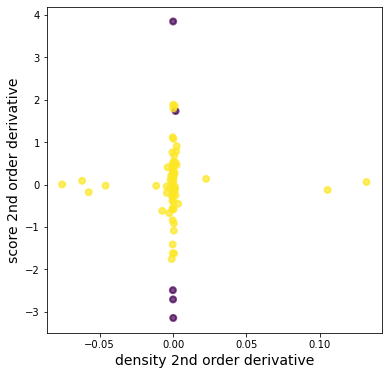

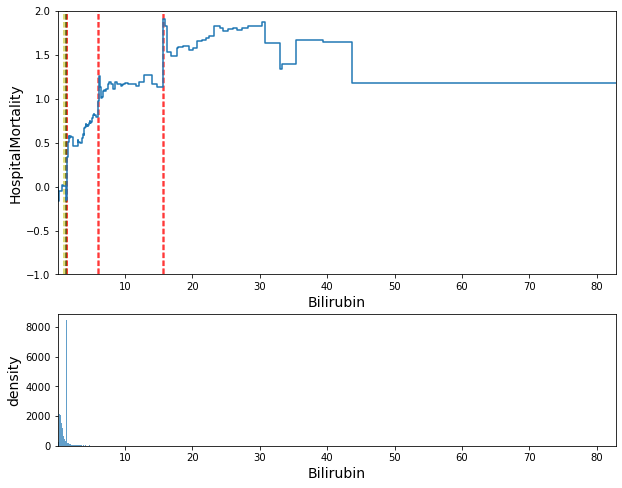

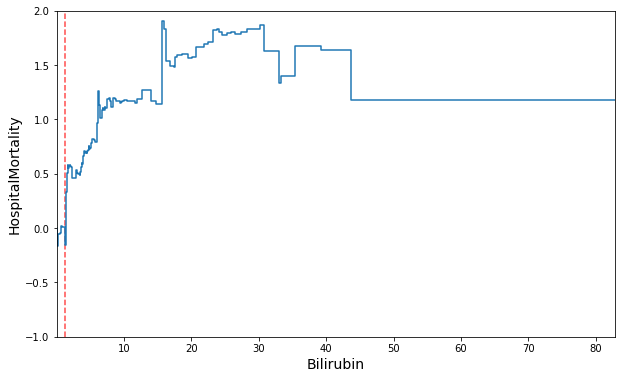

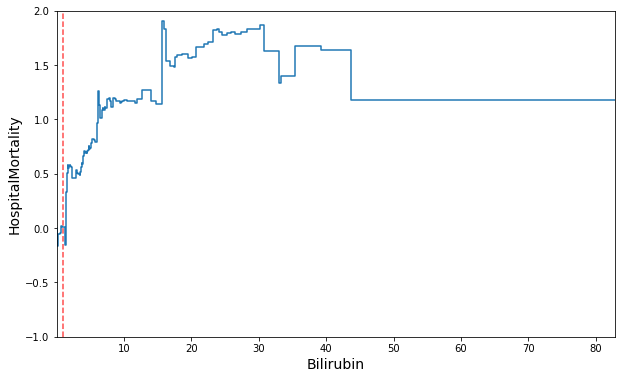

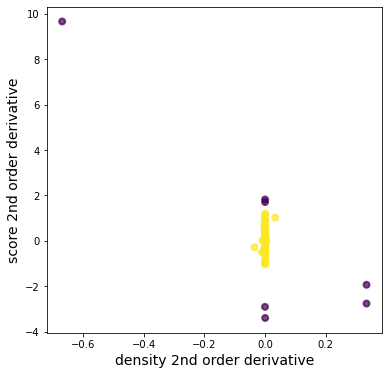

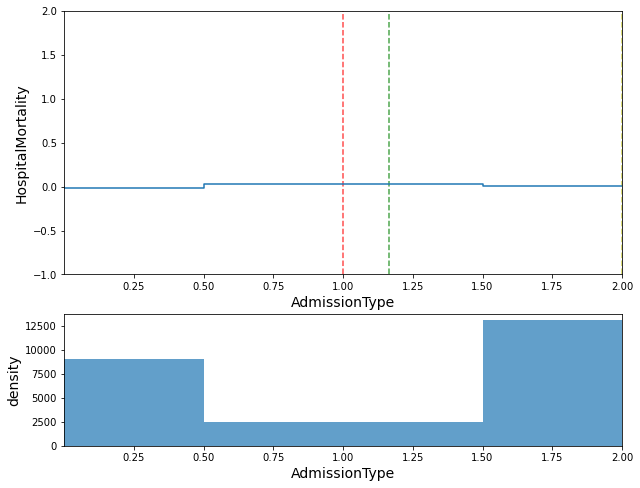

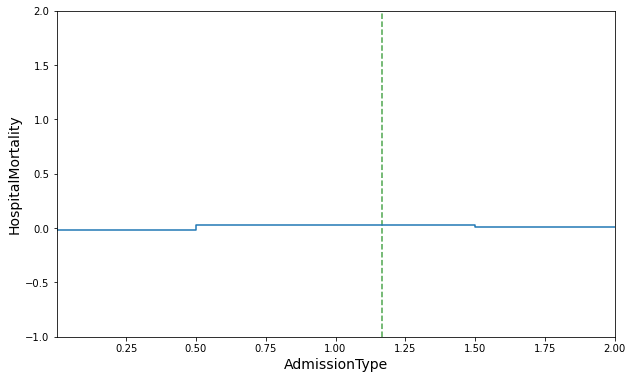

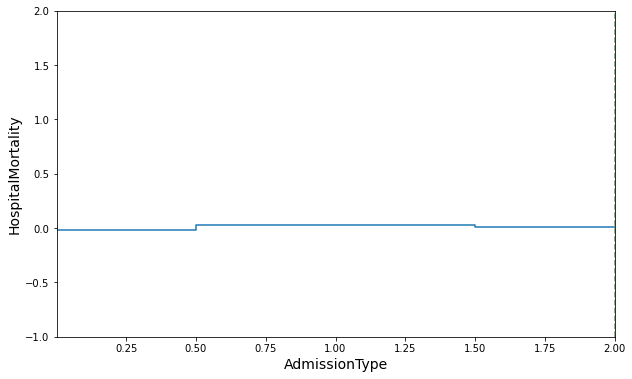

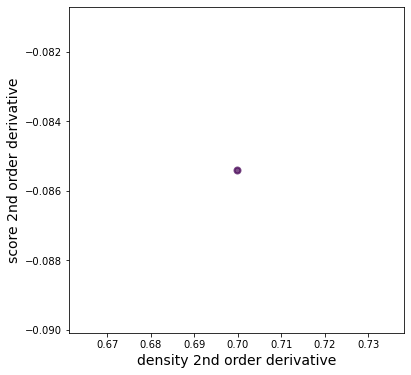

In [17]:
detect_bumps(ebm_mean, data_meanimputed, featureNames, missing_ratios, 'mean', threshold = 0.6)